In [19]:
dataset_path = "./audio_2020_06_15/"
data_folder = "wav_from_silk0510_clips/"
 
%cd $dataset_path

[Errno 2] No such file or directory: './audio_2020_06_15/'
/home/mikelin/Environmental-Sound-Classification/audio_2020_06_15


In [20]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os

In [21]:
df = pd.read_csv('Tencent_breath_meta_data.csv')
df.head()

,filename,fold,target,category
0,7-oRTKR4vkqAI275E5oE7girvIvfpg_tianye_15854553...,0,1,breath
1,7-oRTKR4r28LT-_Q11jQ5KobaeR3QA_syw_15882361256...,0,0,other_sounds
2,7-oRTKR4r4G8wDS3dpUQn0ux6HVVzY_caihongnabian_1...,0,1,breath
3,7-oRTKR4r28LT-_Q11jQ5KobaeR3QA_syw_15885125352...,0,1,breath
4,7-oRTKR4roGcGPJHhHxjWBhNDE5WeE_hanlianyiceshih...,0,1,breath


In [11]:
train = df[df['fold']==0]
valid = df[df['fold']!=0]
print(train)
print(valid)

                                              filename  fold  target  \
0    7-oRTKR4vkqAI275E5oE7girvIvfpg_tianye_15854553...     0       1   
1    7-oRTKR4r28LT-_Q11jQ5KobaeR3QA_syw_15882361256...     0       0   
2    7-oRTKR4r4G8wDS3dpUQn0ux6HVVzY_caihongnabian_1...     0       1   
3    7-oRTKR4r28LT-_Q11jQ5KobaeR3QA_syw_15885125352...     0       1   
4    7-oRTKR4roGcGPJHhHxjWBhNDE5WeE_hanlianyiceshih...     0       1   
..                                                 ...   ...     ...   
434  7-oRTKR4r4G8wDS3dpUQn0ux6HVVzY_caihongnabian_1...     0       1   
435  7-oRTKR4vkqAI275E5oE7girvIvfpg_tianye_15885288...     0       1   
436  7-oRTKR4vkqAI275E5oE7girvIvfpg_tianye_15886100...     0       0   
437  7-oRTKR4vkqAI275E5oE7girvIvfpg_tianye_15854553...     0       1   
438  7-oRTKR4n5dfw3pDz1mDYWyIqH9Qjo_leo-han_1585327...     0       1   

         category  
0          breath  
1    other_sounds  
2          breath  
3          breath  
4          breath  
..            .

In [7]:
wav, sr = librosa.load(data_folder+'/7-oRTKR4iczLHGvtQyk6PgHb9rJ9nc_chao-huang_1585423066528_19_0001-.wav-A-23.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds


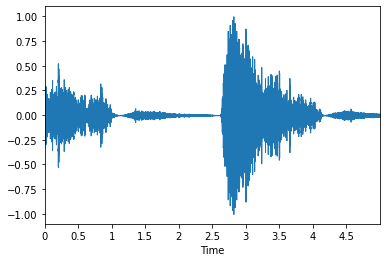

In [7]:
filename = valid[valid['category']=='breath'].iloc[0]['filename']
wav, sr = librosa.load(data_folder+filename, sr=None)
librosa.display.waveplot(wav, sr)

In [22]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [9]:
img = spec_to_image(get_melspectrogram_db(data_folder+filename, sr))
print(img)
print(img.shape)

[[204 194 173 ...  75  76  69]
 [181 189 195 ...  77  82  80]
 [143 165 198 ...  96  90  82]
 ...
 [ 39  41  37 ...  27  21   7]
 [ 32  32  33 ...  18  10   0]
 [ 15  12  19 ...   0   0   0]]
(128, 235)


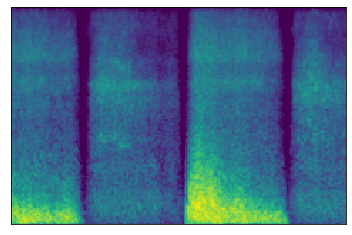

In [10]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db(data_folder+filename, sr)), cmap='viridis')

In [23]:
class Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [24]:
class Breath_Model(nn.Module):
  def __init__(self, input_shape, batch_size=16, num_cats=2):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x


In [25]:
# data_folder = "wav_from_silk0510_clips/"
train_data = Data(data_folder, train, 'filename', 'category')
valid_data = Data(data_folder, valid, 'filename', 'category')

<ipython-input-23-ba416eb7ddd8>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(range(len(df))):


In [17]:
print(train_data.labels)

[0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 

In [26]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [27]:
if torch.cuda.is_available():
  device=torch.device('cuda:7')
else:
  device=torch.device('cpu')

print(device)

cuda:7


In [19]:
model = Breath_Model(input_shape=(1,128,235), batch_size=16, num_cats=2).to(device)

In [34]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [21]:
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCELoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50
train_losses = []
valid_losses = []

In [30]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [23]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

<ipython-input-22-ba14a2a022ae>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1,epochs+1)):


Epoch - 1 Train-Loss : 0.6462103335985115
Epoch - 1 Valid-Loss : 0.8236347947801862 Valid-Accuracy : 0.6545454545454545
Epoch - 2 Train-Loss : 0.37898339544023785
Epoch - 2 Valid-Loss : 0.3125748985580036 Valid-Accuracy : 0.8636363636363636
Epoch - 3 Train-Loss : 0.25188211830598967
Epoch - 3 Valid-Loss : 0.2773319546665464 Valid-Accuracy : 0.8818181818181818
Epoch - 4 Train-Loss : 0.15591259407145636
Epoch - 4 Valid-Loss : 0.4134846499988011 Valid-Accuracy : 0.8
Epoch - 5 Train-Loss : 0.2361895159951278
Epoch - 5 Valid-Loss : 0.2503314459962504 Valid-Accuracy : 0.8818181818181818
Epoch - 6 Train-Loss : 0.12035084808511394
Epoch - 6 Valid-Loss : 0.25863866933754515 Valid-Accuracy : 0.9090909090909091
Epoch - 7 Train-Loss : 0.05859556255329933
Epoch - 7 Valid-Loss : 0.258612545473235 Valid-Accuracy : 0.9272727272727272
Epoch - 8 Train-Loss : 0.04442300274968147
Epoch - 8 Valid-Loss : 0.28415882161685396 Valid-Accuracy : 0.8818181818181818
Epoch - 9 Train-Loss : 0.033000537560188344
Epoc

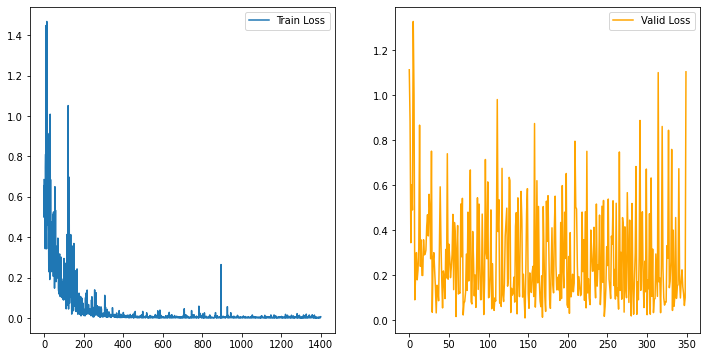

In [25]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [35]:
%mkdir ../trained_models
with open('../trained_models/breath_scratchnet.pth','wb') as f:
  torch.save(model, f)

In [31]:
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,2)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

In [35]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
# lsss_fn = loss = nn.BCELoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)


<ipython-input-30-ba14a2a022ae>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1,epochs+1)):


Epoch - 1 Train-Loss : 0.13896667348620081
Epoch - 1 Valid-Loss : 0.5952655641095979 Valid-Accuracy : 0.8818181818181818
Epoch - 2 Train-Loss : 0.04154409479399744
Epoch - 2 Valid-Loss : 0.561677370752607 Valid-Accuracy : 0.8272727272727273
Epoch - 3 Train-Loss : 0.00878230478597938
Epoch - 3 Valid-Loss : 0.45783691693629536 Valid-Accuracy : 0.8909090909090909
Epoch - 4 Train-Loss : 0.015358387534174003
Epoch - 4 Valid-Loss : 0.5420890876225063 Valid-Accuracy : 0.8909090909090909
Epoch - 5 Train-Loss : 0.0509638637304306
Epoch - 5 Valid-Loss : 0.5572224514825004 Valid-Accuracy : 0.8818181818181818
Epoch - 6 Train-Loss : 0.10358368292716998
Epoch - 6 Valid-Loss : 0.7307963429817131 Valid-Accuracy : 0.8454545454545455
Epoch - 7 Train-Loss : 0.06812277181390007
Epoch - 7 Valid-Loss : 0.4993940687605313 Valid-Accuracy : 0.8545454545454545
Epoch - 8 Train-Loss : 0.04323587616922201
Epoch - 8 Valid-Loss : 0.39391496990408215 Valid-Accuracy : 0.8454545454545455
Epoch - 9 Train-Loss : 0.052683

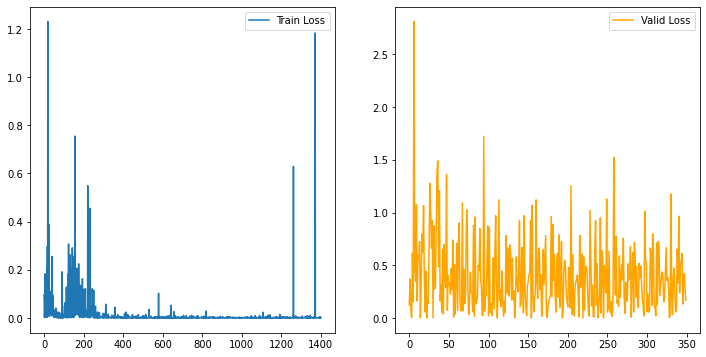

In [36]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [37]:
print("The state dict keys: \n\n", resnet_model.state_dict().keys())

The state dict keys: 

 odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.bn1.num_batches_tracked', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight'

In [52]:
# %mkdir ../trained_models

checkpoint = {'model': resnet_model,
              'state_dict': resnet_model.state_dict(),
              'optimizer' : optimizer.state_dict()}


torch.save(checkpoint, '../trained_models/breath_resnet.pth')


In [45]:
import glob
test_data = []
test_labels = []
'''load testing data'''
test_folder = "../inference_clips_sample/"
positive_example_folder = test_folder+"is_breath_0"
positive_example_list = sorted(glob.glob(positive_example_folder+"/*"))

negative_example_folder = test_folder+"is_breath_1"
negative_example_list = sorted(glob.glob(negative_example_folder+"/*"))

for f in positive_example_list:
    wav, sr = librosa.load(f, sr=None)
    print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')
    test_data.append(spec_to_image(get_melspectrogram_db(f))[np.newaxis,...])
    test_labels.append(0)

for f in negative_example_list:
    wav, sr = librosa.load(f, sr=None)
    print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')
    test_data.append(spec_to_image(get_melspectrogram_db(f))[np.newaxis,...])
    test_labels.append(1)

print(test_labels)



Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
[0, 0, 0, 1, 1, 1]


In [50]:
for i, _ in enumerate(test_data):
    spec_t=torch.tensor(test_data[i][0]).to(device, dtype=torch.float32)
    pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
    ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
    print(ind)


0
0
0
1
1
1
